In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import *
from sympy import *

## Modified Rodrigues Parameters:

The mapping from a set of given Rodrigues parameters: $\sigma = (\sigma_1, \sigma_2, \sigma_3) $ to its corresponding DCM can be achieved directly via the compact vector computation:

$$
[C] = [I_{3x3}] + \frac{8[\tilde{\sigma}]^2 - 4(1 - \sigma^2)[\tilde{\sigma}]}{(1 + \sigma^2)^2}
$$

Where $[I_{3x3}]$ is the identity matrix and $[\tilde{\sigma}]$ is a skew symetric matrix corresponding to the given set of MRPs.

In [2]:
def skew(x):
    return np.array([[0, -x[2], x[1]],
                     [x[2], 0, -x[0]],
                     [-x[1], x[0], 0]])

def MRP_to_DCM(a):
    a_norm = np.linalg.norm(a)
    return np.eye(3) + (1/(1 + a_norm**2))**2 * ((8 * np.dot(skew(a),skew(a))) - 4 * (1 - a_norm**2) * skew(a))
    

In [3]:
a = np.array([0.1, 0.2, 0.3])

print(MRP_to_DCM(a))

[[ 0.19975377  0.91720529 -0.34472145]
 [-0.67097568  0.38442598  0.63404124]
 [ 0.71406587  0.10464758  0.69221299]]


The relationship between the set of quaternions and the MRPs is as follows:


$$
\sigma_i = \frac{\beta_i}{1 + \beta_0}
$$

Shadow set:
$$
\sigma_i = \frac{-\beta_i}{1 - \beta_0}
$$

$i \in 1, 2, 3$


The inverse mappings from the DCM to the MRPs are as follows: 

$$
\zeta = \sqrt{Trace[C] + 1}
$$

$$
\frac{1}{\zeta(\zeta + 2)} \left[\begin{array}{cc} 
C_{23} - C_{32} \\
C_{31} - C_{13} \\
C_{12} - C_{21} 
\end{array}\right] 
$$

In [4]:
def Quaternion_to_MRP(q):
    sig = [q[i]/(1+q[0]) for i in range(1,len(q))]
    sig_shadow = [-q[i]/(1-q[0]) for i in range(1,len(q))]
    return sig, sig_shadow
 
def DCM_to_MRP(C):
    z = np.sqrt(C.trace() + 1)
    return (1/(z*(z+2))) * np.array([[C[1][2] - C[2][1]],
                                     [C[2][0] - C[0][2]],
                                     [C[0][1] - C[1][0]]])

In [5]:
G = np.array([[ 0.763314, 0.0946746, -0.639053],
              [-0.568047, -0.372781, -0.733728],
              [-0.307692,  0.923077, -0.230769]])

print(DCM_to_MRP(G))

[[-0.49999988]
 [ 0.09999998]
 [ 0.19999983]]


In [13]:
y = np.array([2, 2, 2])
a_norm = np.linalg.norm(y)

#print(np.eye(3) * (1 - a_norm**2))

#print(np.dot(np.eye(3), (1 - a_norm**2)))

#print(np.dot(y, y.T))

print(y)

[2 2 2]


## MRP Kinematic Differential Equations

$$
\dot{\sigma} = \frac{1}{4}[(1 - \sigma^2)[I_{3x3}] + 2[\tilde{\sigma}] + 2\sigma\sigma^T]\omega
$$

$$
\equiv \frac{1}{4}[B(\sigma)]\omega
$$

In [120]:
#Initial Conditions:
dt = 0.1
T = 42
N = int(T/dt)
y0 = np.array([0.4, 0.2, -0.1])
t = 0

"""
The MRP consitions are limited explicitly to short rotations only using the conditions: 

if normalisation of MRP initial condt. vector > 1: q_i -> -q_i/normalisation^2. Otherwise continue.

"""


def MRP_Kinematic_Eq(t, y):
    
    q_1, q_2, q_3 = y
    
    norm = (np.dot(y,y)/sqrt(np.dot(y,y)))
    
    w = np.array([sin(0.1 * t), 0.01, cos(0.1 * t)], dtype = np.float64)
    
    k = np.deg2rad(20)
    
    Q = np.array([[1 - norm**2 + 2 * q_1**2, 2 * (q_1 * q_2 - q_3), 2 * (q_1 * q_3 + q_2)],
                  [2 * (q_1 * q_2 + q_3), 1 - norm**2 + 2 * q_2**2, 2 * (q_2 * q_3 - q_1)],
                  [2 * (q_1 * q_3 - q_2), 2 * (q_2 * q_3 + q_1), 1 - norm**2 + 2 * q_3**2]] , dtype = np.float64)
    
    dQdt = np.dot(Q, w) * k *1/4
    
    return dQdt
    


def RK4(f, dt, y0, t):
    
    y_plot = np.zeros((N-1,3))
    t_plot = []
                      
    for i in range(0, N-1): 
    
        f1 = f(t, y0)
        f2 = f(t + (dt / 2), y0 + (dt / 2) * f1)
        f3 = f(t + (dt / 2), y0 + (dt / 2) * f2)
        f4 = f(t + dt, y0 + dt * f3)
    
        y0 = y0 + (dt / 6) * (f1 + 2 * f2 + 2 * f3 + f4)
        
        t = t + dt
        
        #Switching the terms if the normalisation conditions are greater than 1.
        norm = (np.dot(y0,y0)/sqrt(np.dot(y0,y0)))
        
        if norm > 1.0:
        
            y0[0] = -y0[0] / norm**2
        
            y0[1] = -y0[1] / norm**2
        
            y0[2] = -y0[2] / norm**2
        
        y_plot[i] = y0; t_plot.append(t)
        
        
         
    return y_plot, t_plot


solution = RK4(MRP_Kinematic_Eq, dt, y0, t)


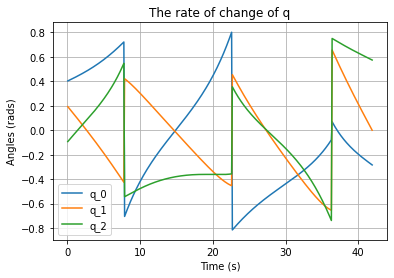

In [121]:
plt.plot(solution[1], solution[0][:,0], label = "q_0")
plt.plot(solution[1], solution[0][:,1], label = "q_1")
plt.plot(solution[1], solution[0][:,2], label = "q_2")

plt.legend()
plt.title("The rate of change of q")
plt.xlabel("Time (s)")
plt.ylabel("Angles (rads)")
plt.grid(true)

In [122]:
#Finding the norm of the vector (i.e: sqrt(a_1^2 + a_2^2 + a_3^2)) at 42s.
print(sqrt((solution[0][:,0][-1])**2 + (solution[0][:,1][-1])**2 + (solution[0][:,2][-1])**2 ))

0.640052885898210
